# Нормальность распределения и тесты

**В данном ноутбуке я рассмотрю применимость разных функций для нормального распределения и проверочный тест**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

****
### Рассмотрим пример задачи с это одной из ключевых метрик (коэффициент NPL, Non-performing loans) ###
Микрокредитные организации имеют значение доли проблемных кредитов (NPL) в кредитном портфеле в среднем на уровне 7,45% по сектору. Стандартное отклонение равно 1.36%. Считаем, что распределение является нормальным. 

Чему равна вероятность того, что случайно выбранная микрокредитная организация будет иметь долю NPL в портфеле, не превышающую 8,99%?

In [3]:
# Создадим норм. распределение с μ=0.0745 σ=0.0136
mu = 0.0745
sigma = 0.0136
x = 0.0899
dist = stats.norm(mu, sigma)

Для расчета используем **кумулятивную функцию распределения (cumulative distribution function, CDF)** от значения х, которая определяет долю наблюдений выборки, значения которых меньше или равно х, иначе говоря вероятность попадания случайной величины в интервал от −∞ до х

In [4]:
# Расчитаем вероятность CDF(x)
probability = dist.cdf(x)

print(f'Вероятность того, что NPL не превышает 8.99%: {round(probability, 5)}')

Вероятность того, что NPL не превышает 8.99%: 0.87126


Чтобы убедиться, что расчёт через `scipy.stats.norm(mu, sigma).cdf(x)` корректен, сделаем проверку через **z-score**.

In [5]:
# z-score вычисляется как (x − μ) / σ и показывает положение конкретного значения относительно среднего
z = (x - mu) / sigma

In [6]:
stats.norm.cdf(z) == probability

True

Ответ: Полученное значение вероятности показывает, что около 87% микрокредитных организаций в секторе имеют долю проблемных кредитов не выше 8.99%, при предположении нормального распределения показателя NPL.

**А что делать когда мы не знаем является ли наше распределение нормальным?** 
****
### Тесты на проверку нормальности распределения
Тесты на нормальность сравнивают проверяемую выборку с теоретическим распределением (в нашем случае с нормальным) с такими же значениями среднего и стандартного отклонения.
<br>
_* Рассмотрим тест Колмогорова-Смирнова на наборе данных ежедневных изменения индекса S&P 500_

**Проверяем гипотезу о нормальности распределения доходностей S&P 500.** \
Нулевая гипотеза (H₀): распределение является нормальным. \
Альтернативная гипотеза (H₁): распределение отличается от нормального.

In [7]:
# Загрузим набор данных из 1254 значений ежедневных изменения индекса S&P 500
df = pd.read_csv('SP_500_returns.csv', delimiter=';')
df.head(3)

,Date,Return_SP_500
0,02.12.2014,0.006384
1,03.12.2014,0.003765
2,04.12.2014,-0.001162


In [8]:
data = df['Return_SP_500'].dropna()

mu, sigma = data.mean(), data.std(ddof=1)
dist = stats.norm(mu, sigma)

# Диапазон для кривой
x_vals = np.linspace(data.min(), data.max(), 1000)

In [9]:
# KS-тест
ks_stat, ks_p = stats.kstest(data, 'norm', args=(mu, sigma))

In [10]:
print(f'Можем отвергнуть нулевую гипотезу о нормальности распределения: {ks_p < 0.05}')

Можем отвергнуть нулевую гипотезу о нормальности распределения: True


_* Следует отметить, что статистика Колмогорова–Смирнова определяется как максимальное вертикальное расстояние между эмпирической и теоретической функциями распределения (CDF)._
****
**Построим графики для наглядности PDF(x) и CDF(x)** \
_(PDF описывает форму распределения, CDF — накопленную вероятность)_

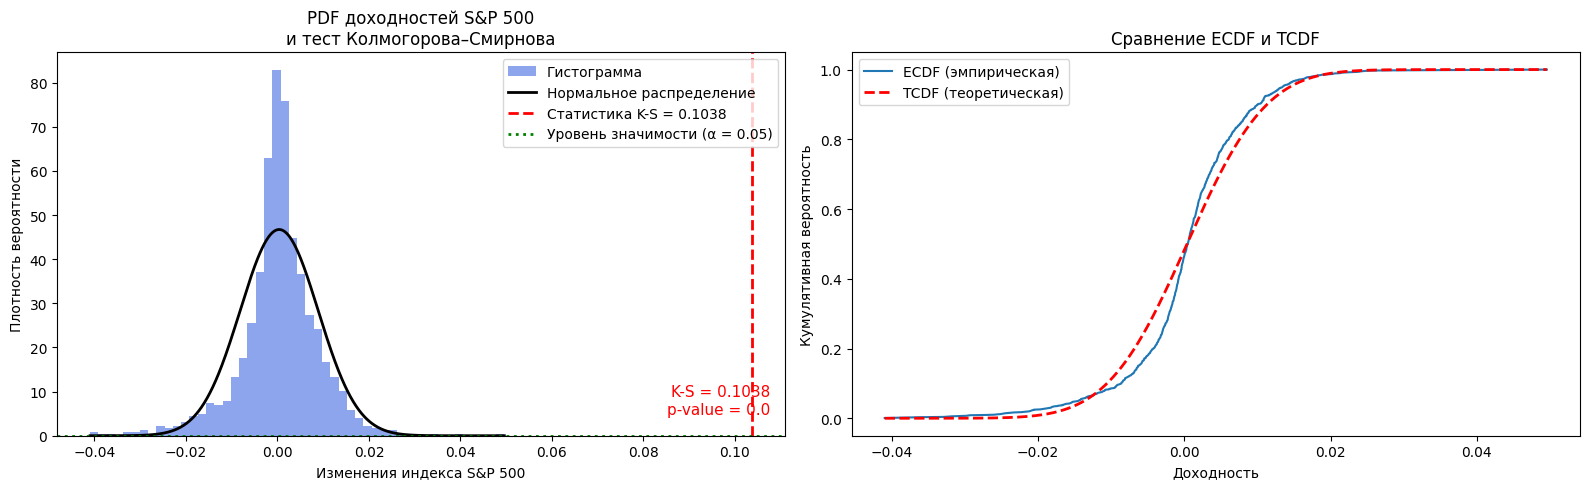

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# PDF
axes[0].hist(data, bins=50, density=True, alpha=0.6, color='royalblue', label='Гистограмма')
axes[0].plot(x_vals, dist.pdf(x_vals), color='black', linewidth=2, label='Нормальное распределение')
axes[0].axvline(ks_stat, color='red', linestyle='--', linewidth=2, label=f'Статистика K-S = {ks_stat:.4f}')
axes[0].axhline(0, color='green', linestyle=':', linewidth=2, label='Уровень значимости (α = 0.05)')

axes[0].text(
    0.98, 0.05,
    f'K-S = {ks_stat:.4f}\np-value = {round(ks_p, 4)}',
    transform=axes[0].transAxes,
    horizontalalignment='right',
    verticalalignment='bottom',
    fontsize=11,
    color='red'
)
axes[0].set_title('PDF доходностей S&P 500\nи тест Колмогорова–Смирнова')
axes[0].set_xlabel('Изменения индекса S&P 500')
axes[0].set_ylabel('Плотность вероятности')
axes[0].legend()

# ECDF
sorted_data = np.sort(data)
empirical_cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

axes[1].plot(sorted_data, empirical_cdf, label='ECDF (эмпирическая)')

# TCDF
axes[1].plot(x_vals, dist.cdf(x_vals), color='red', linestyle='--', linewidth=2, label='TCDF (теоретическая)')

axes[1].set_title('Сравнение ECDF и TCDF')
axes[1].set_xlabel('Доходность')
axes[1].set_ylabel('Кумулятивная вероятность')
axes[1].legend()
plt.tight_layout()
plt.show()

Слева показана эмпирическая плотность доходностей S&P 500 с наложенной нормальной кривой и результатами теста Колмогорова–Смирнова. \
Справа представлено сравнение эмпирической и теоретической функций распределения (ECDF и TCDF), иллюстрирующее расхождения, лежащие в основе KS-статистики.

#### Вывод: результаты теста Колмогорова–Смирнова (p-value < 0.05) подтверждают статистически значимое отклонение распределения от нормального.